In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [21]:
A,D = 1.0,2.0
tau_real = A/D
delta_t_list=np.linspace(0.01,1,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [5]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

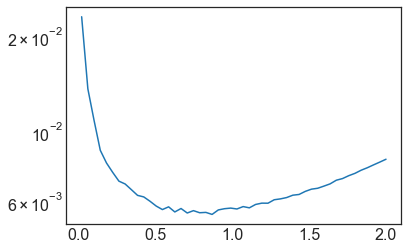

In [22]:
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3])

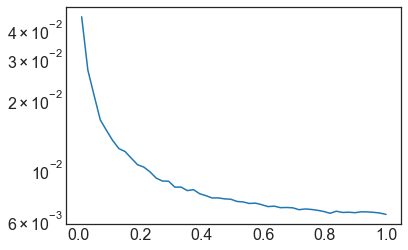

In [7]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [8]:
A,D = 1.0,2.0
tau_real = D/A
delta_t_list=np.linspace(0.01,1,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

0.15142857142857144


In [9]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=20000

In [10]:
trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:14<00:00, 550.53draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c21ff58d0>,
      dtype=object)

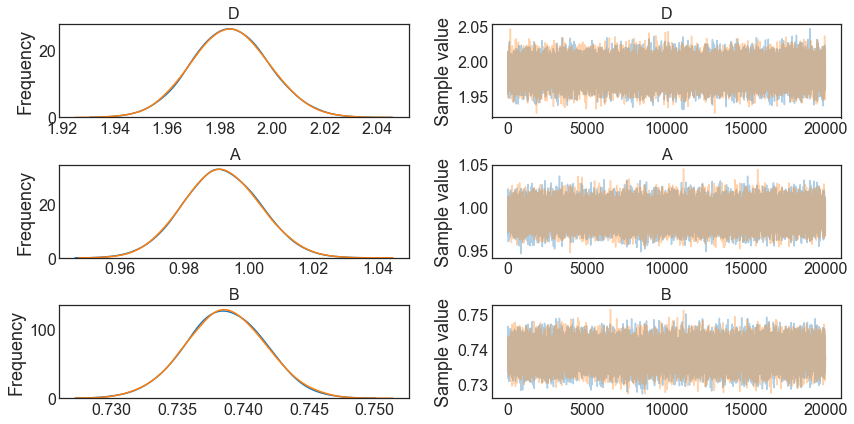

In [11]:
pm.traceplot(trace)

In [12]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:16<00:00, 532.83draws/s]
The acceptance probability does not match the target. It is 0.8878604257688776, but should be close to 0.8. Try to increase the number of tuning steps.


0.030204081632653063


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:23<00:00, 493.94draws/s]
The acceptance probability does not match the target. It is 0.8868184718100317, but should be close to 0.8. Try to increase the number of tuning steps.


0.05040816326530612


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:23<00:00, 488.25draws/s]
The acceptance probability does not match the target. It is 0.8791559189586702, but should be close to 0.8. Try to increase the number of tuning steps.


0.07061224489795918


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:20<00:00, 511.86draws/s]


0.09081632653061224


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:19<00:00, 512.64draws/s]
The acceptance probability does not match the target. It is 0.8829859959508816, but should be close to 0.8. Try to increase the number of tuning steps.


0.11102040816326529


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:21<00:00, 503.57draws/s]


0.13122448979591836


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:19<00:00, 514.45draws/s]


0.15142857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:20<00:00, 510.15draws/s]
The acceptance probability does not match the target. It is 0.880306026754848, but should be close to 0.8. Try to increase the number of tuning steps.


0.1716326530612245


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:19<00:00, 512.68draws/s]


0.19183673469387755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:24<00:00, 487.01draws/s]
The acceptance probability does not match the target. It is 0.8888854596046103, but should be close to 0.8. Try to increase the number of tuning steps.


0.2120408163265306


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:22<00:00, 499.76draws/s]


0.23224489795918368


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:29<00:00, 460.40draws/s]
The acceptance probability does not match the target. It is 0.8875879071170303, but should be close to 0.8. Try to increase the number of tuning steps.


0.2524489795918367


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:24<00:00, 486.85draws/s]
The acceptance probability does not match the target. It is 0.8894288401090014, but should be close to 0.8. Try to increase the number of tuning steps.


0.2726530612244898


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:22<00:00, 495.28draws/s]
The acceptance probability does not match the target. It is 0.8853580556975372, but should be close to 0.8. Try to increase the number of tuning steps.


0.29285714285714287


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:21<00:00, 501.59draws/s]


0.3130612244897959


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:26<00:00, 475.58draws/s]


0.333265306122449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:21<00:00, 506.16draws/s]
The acceptance probability does not match the target. It is 0.8822559980542907, but should be close to 0.8. Try to increase the number of tuning steps.


0.35346938775510206


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:36<00:00, 425.09draws/s]


0.3736734693877551


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:16<00:00, 535.78draws/s]
The acceptance probability does not match the target. It is 0.8800161163178807, but should be close to 0.8. Try to increase the number of tuning steps.


0.39387755102040817


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:26<00:00, 474.55draws/s]
The acceptance probability does not match the target. It is 0.8883022134237737, but should be close to 0.8. Try to increase the number of tuning steps.


0.4140816326530612


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:24<00:00, 485.36draws/s]
The acceptance probability does not match the target. It is 0.8843442308631161, but should be close to 0.8. Try to increase the number of tuning steps.


0.4342857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:25<00:00, 479.51draws/s]
The acceptance probability does not match the target. It is 0.8935157428436903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813899399811538, but should be close to 0.8. Try to increase the number of tuning steps.


0.45448979591836736


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:22<00:00, 499.36draws/s]


0.4746938775510204


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:23<00:00, 491.90draws/s]


0.49489795918367346


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:24<00:00, 485.37draws/s]
The acceptance probability does not match the target. It is 0.88855611001427, but should be close to 0.8. Try to increase the number of tuning steps.


0.5151020408163265


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:26<00:00, 472.84draws/s]
The acceptance probability does not match the target. It is 0.8848652565096765, but should be close to 0.8. Try to increase the number of tuning steps.


0.5353061224489796


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:28<00:00, 461.43draws/s]
The acceptance probability does not match the target. It is 0.892366966902241, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838645413341726, but should be close to 0.8. Try to increase the number of tuning steps.


0.5555102040816327


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:25<00:00, 480.58draws/s]
The acceptance probability does not match the target. It is 0.8866519163050983, but should be close to 0.8. Try to increase the number of tuning steps.


0.5757142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:27<00:00, 466.71draws/s]
The acceptance probability does not match the target. It is 0.884164015791079, but should be close to 0.8. Try to increase the number of tuning steps.


0.5959183673469388


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:23<00:00, 491.49draws/s]


0.6161224489795918


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:32<00:00, 440.95draws/s]
The acceptance probability does not match the target. It is 0.8981678365337469, but should be close to 0.8. Try to increase the number of tuning steps.


0.6363265306122449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:34<00:00, 431.96draws/s]
The acceptance probability does not match the target. It is 0.9013641250654368, but should be close to 0.8. Try to increase the number of tuning steps.


0.656530612244898


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:21<00:00, 500.10draws/s]


0.676734693877551


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:19<00:00, 513.87draws/s]


0.6969387755102041


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:14<00:00, 546.72draws/s]


0.7171428571428571


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:21<00:00, 502.27draws/s]
The acceptance probability does not match the target. It is 0.8894336739125621, but should be close to 0.8. Try to increase the number of tuning steps.


0.7373469387755102


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:18<00:00, 519.92draws/s]
The acceptance probability does not match the target. It is 0.8823516829621367, but should be close to 0.8. Try to increase the number of tuning steps.


0.7575510204081632


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:19<00:00, 517.44draws/s]


0.7777551020408163


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:18<00:00, 524.94draws/s]
The acceptance probability does not match the target. It is 0.8819524152329018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807839589183974, but should be close to 0.8. Try to increase the number of tuning steps.


0.7979591836734694


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:21<00:00, 503.33draws/s]
The acceptance probability does not match the target. It is 0.8869368109936824, but should be close to 0.8. Try to increase the number of tuning steps.


0.8181632653061224


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:16<00:00, 533.64draws/s]


0.8383673469387755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:16<00:00, 534.24draws/s]


0.8585714285714285


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:22<00:00, 496.74draws/s]
The acceptance probability does not match the target. It is 0.8942676538453224, but should be close to 0.8. Try to increase the number of tuning steps.


0.8787755102040816


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:17<00:00, 530.14draws/s]


0.8989795918367347


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:16<00:00, 538.60draws/s]


0.9191836734693878


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:18<00:00, 521.25draws/s]
The acceptance probability does not match the target. It is 0.8809301409715896, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881752326158024, but should be close to 0.8. Try to increase the number of tuning steps.


0.9393877551020408


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:20<00:00, 506.87draws/s]
The acceptance probability does not match the target. It is 0.8851168392193605, but should be close to 0.8. Try to increase the number of tuning steps.


0.9595918367346938


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:28<00:00, 465.44draws/s]
The acceptance probability does not match the target. It is 0.8989670204494812, but should be close to 0.8. Try to increase the number of tuning steps.


0.9797959183673469


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:16<00:00, 536.86draws/s]


1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:16<00:00, 537.94draws/s]


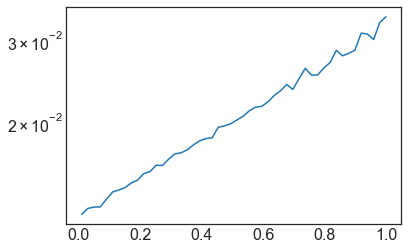

In [13]:
plt.semilogy(delta_t_list,result_array.T[3])

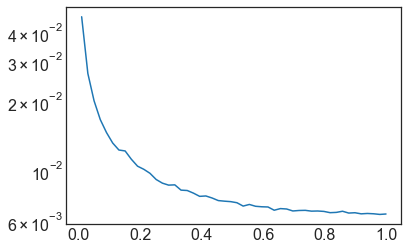

In [14]:
plt.semilogy(delta_t_list,result_array.T[1])

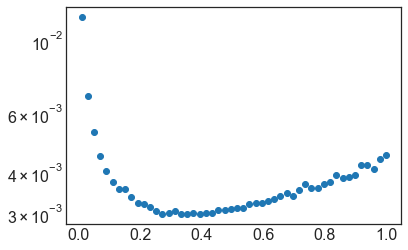

In [15]:
dtau = np.sqrt(result_array.T[1]**2/D**2+A**2/D**4*result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau/tau_real,"o")

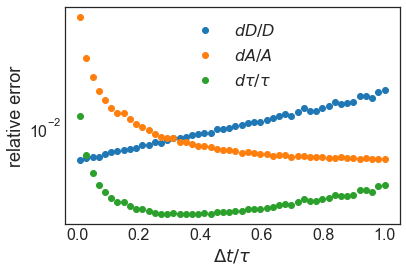

In [16]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

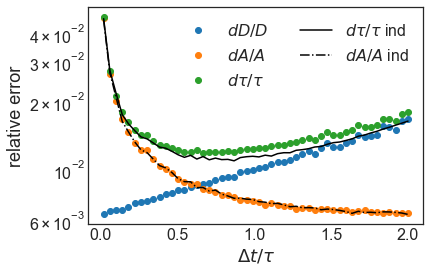

In [25]:
plt.semilogy(delta_t_list/tau_real,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list/tau_real,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list/tau_real,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[1]/A,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_2.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")